In [1]:
import time
from collections import namedtuple, deque
import numpy as np
import pickle
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

from agent import Agent

# Env and Agent

In [2]:
# init the enviromnet
env = UnityEnvironment(file_name="Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# read out the state and action size
env_info = env.reset(train_mode=True)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# init agent
agent = Agent(state_size, action_size)

# Training

In [4]:
# Parameter

n_episodes = 2000
n_rolling_average = 100
update_every = 4
epsilon = 0.01
path_latest_model = 'model/checkpoint.pth'

# ========================================================================

t0 = time.time()
scores = []
rolling_average_scores = deque(maxlen=n_rolling_average)
smoothed_scores = []
best_score = -1e19
best_episode = -1

print(' Time Evolved | Episode | Rolling Average Score ')
print('--------------+---------+-----------------------')

for i in range(n_episodes):

    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    
    t = 0
    while True:

        # choose action
        action = agent.act(state, epsilon=epsilon)

        # evolve environment
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]                
        done = env_info.local_done[0]               

        # store experience
        agent.store_experience(state, action, reward, next_state, done)
        
        # learn every update_every time step
        if t%update_every == 0:
            agent.learn()

        # updating
        score += reward                             
        state = next_state   
        t += 1
        if done:                                  
            break

    # do the score
    dt = (time.time()-t0)
    scores.append(score)
    rolling_average_scores.append(score)
    sm = np.mean(rolling_average_scores) if len(rolling_average_scores)==n_rolling_average else np.nan
    smoothed_scores.append(sm)

    # print progress
    print(f"\r {dt/60:>8.1f} min | {i+1:>7d} | {sm:>21.3f}", end="")
    if (i+1)%n_rolling_average==0:
        print('')
    
    # save network
    agent.save_q_network(path_latest_model)
    
env.close()

 Time Evolved | Episode | Rolling Average Score 
--------------+---------+-----------------------
      1.6 min |     100 |                -0.060
      3.2 min |     200 |                -0.010
      4.7 min |     300 |                 0.260
      6.3 min |     400 |                 2.230
      7.9 min |     500 |                 7.230
      9.5 min |     600 |                 8.940
     10.9 min |     700 |                10.540
     12.4 min |     800 |                14.930
     13.8 min |     900 |                15.810
     15.4 min |    1000 |                14.890
     16.8 min |    1100 |                15.590
     18.2 min |    1200 |                15.680
     19.8 min |    1300 |                16.590
     21.2 min |    1400 |                16.560
     22.7 min |    1500 |                17.080
     24.2 min |    1600 |                16.830
     25.7 min |    1700 |                16.830
     27.1 min |    1800 |                15.760
     28.6 min |    1900 |             

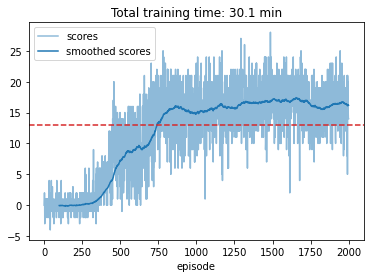

In [10]:
plt.plot(scores, alpha=0.5, label='scores')
plt.plot(smoothed_scores, color='tab:blue', label='smoothed scores')
plt.axhline(13, color='tab:red', linestyle='--')
plt.legend()
plt.xlabel('episode')
plt.savefig('model/training_history.png')
plt.title(f'Total training time: {dt/60:.1f} min')
plt.show()